# Probabilistic Graphical Models for Digital Twins

Probabilistic Graphical Models (PGMs) are a rich framework for encoding complex distributions over high-dimensional spaces using graphs. They combine probability theory and graph theory to provide a compact and intuitive representation of joint probability distributions.  

PGMs are widely used in machine learning, statistics, and artificial intelligence for tasks such as reasoning, prediction, and learning from data. There are two main types of PGMs:

- **Bayesian Networks (Directed Graphical Models):** Represent dependencies using directed edges.
- **Markov Networks (Undirected Graphical Models):** Represent dependencies using undirected edges.

By leveraging the structure of the graph, PGMs enable efficient computation and inference in complex probabilistic models.  

In this notebook, we will define a PGM for the examples/robot_pathing digital twin and use it to refine the inference of the robot's position.  

The RobotPathingSetup is a Singleton class which defines the state domain and the ActionCPD instances for the discretized state update.  

In [1]:
from examples.robot_pathing.common import RobotPathingSetup

setup = RobotPathingSetup()

print(repr(setup.state_domain))
print(f"actions {setup.actions}")

/home/yaevon/miniforge3/envs/test/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DiscreteDomain['x', 'y'] len 25 value shape (2,)
    x [0 1 2 3 4]
    y [0 1 2 3 4]
actions [stay, north, south, west, east]


The physical and digital state coincides: both are discrete 2d coordinates.  

The simulation of the physical asset will be constructed from the Actions, through the core.asset_components.state_update.ActionUpdateComponent.  
In this simplified example, the physical state is itself discrete.  

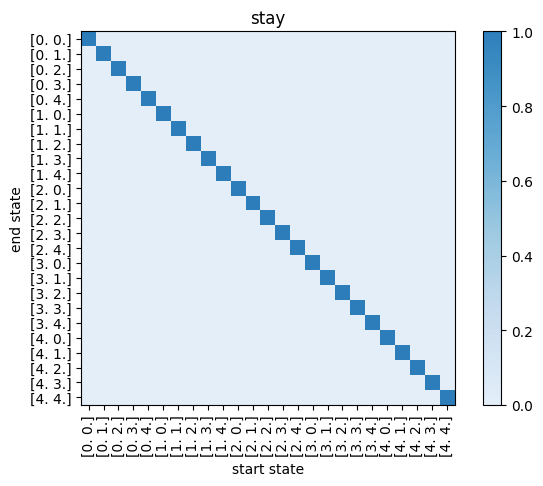

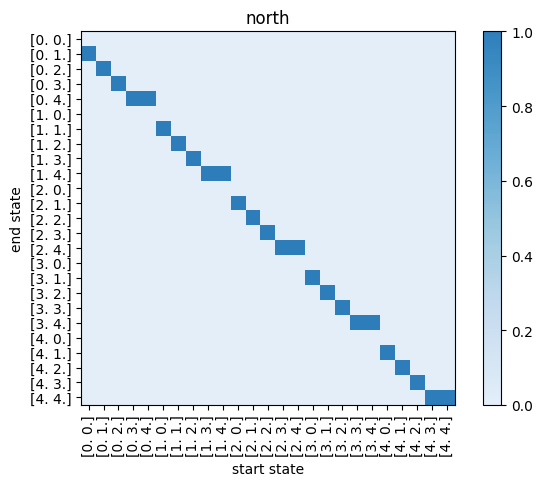

In [2]:
import matplotlib.pyplot as plt

from pgmtwin.core.action import plot_action_transitions

a = setup.actions[0]
plot_action_transitions(a)

plt.title(a)
plt.show()
plt.close()

a = setup.actions[1]
plot_action_transitions(a)

plt.title(a)
plt.show()
plt.close()

The observation of the physical state, however, come from the radii and angles measured by some beacons scattered in the environment.  
The RobotPathingBeaconObserver class takes the positions of the beacons and optional noise parameters, which will corrupt the robot's position as seen by the beacons.  

The inverse problem takes the beacon's data and estimates the current robot's position, assuming that the beacons' positions are known.

true_pos [2 3]
20 inverse problem solutions:
[[1.57197802 1.54875662]
 [2.25071743 2.0820868 ]
 [2.47138393 2.70830132]
 [0.93217243 3.88665141]
 [2.46187178 3.0364748 ]
 [1.1987429  3.00794045]
 [1.72385092 3.22065178]
 [2.0436552  2.44794818]
 [1.80355529 3.1718072 ]
 [2.50508221 3.0664419 ]
 [2.21353681 2.9447556 ]
 [2.58858256 3.5778177 ]
 [1.03087116 2.18138077]
 [1.75102222 3.65915162]
 [1.93557851 1.95150103]
 [1.37194158 2.88088031]
 [1.73138638 2.29759786]
 [1.59638937 2.84714186]
 [1.84346432 4.07298907]
 [2.45807564 2.36695943]]
20 inverse problem solutions discretized
[[2. 2.]
 [2. 2.]
 [2. 3.]
 [1. 4.]
 [2. 3.]
 [1. 3.]
 [2. 3.]
 [2. 2.]
 [2. 3.]
 [3. 3.]
 [2. 3.]
 [3. 4.]
 [1. 2.]
 [2. 4.]
 [2. 2.]
 [1. 3.]
 [2. 2.]
 [2. 3.]
 [2. 4.]
 [2. 2.]]
estimated_pos [2. 2.]


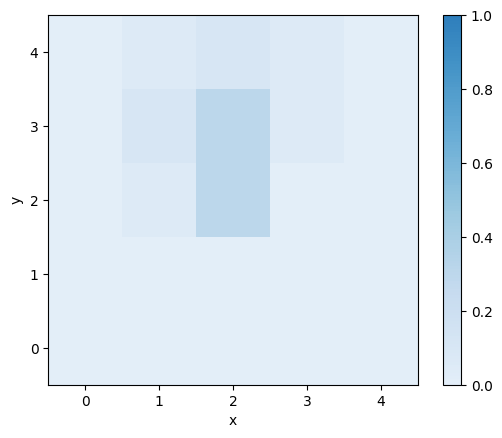

In [3]:
import numpy as np
from examples.robot_pathing.common import (
    RobotPathingBeaconObserver,
    RobotPathingInverseSolverMean,
    plot_map,
)

observer = RobotPathingBeaconObserver(setup.beacons_coords, std=1)
inv_solver = RobotPathingInverseSolverMean(setup.beacons_coords)

n_samples = 20

true_pos = np.array([2, 3])
print(f"true_pos {true_pos}")

obs = np.array([observer.get_observation(true_pos) for _ in range(n_samples)])

estimates = inv_solver(obs)
print(f"{n_samples} inverse problem solutions:")
print(estimates)

estimates = setup.state_domain.values2values(estimates)
print(f"{n_samples} inverse problem solutions discretized")
print(estimates)

state_distro = np.zeros(len(setup.state_domain))
for e in estimates:
    state_distro[setup.state_domain.values2index(e)] += 1
state_distro /= np.sum(state_distro)

estimated_pos = setup.state_domain.index2values(np.argmax(state_distro))
print(f"estimated_pos {estimated_pos}")


plot_map(state_distro, setup)
plt.show()
plt.close()

Let us compute a confusion matrix for the inverse problem and store for future use.

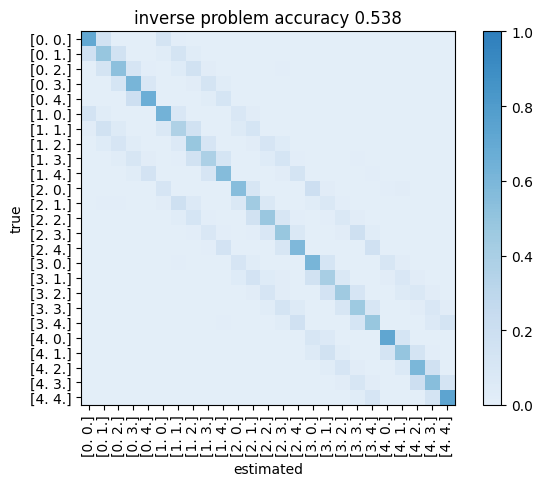

In [4]:
import os
from pgmtwin.core.utils import plot_discrete_domain_confusion_matrix

n_states = len(setup.state_domain)

inv_solver_conf_matrix_fname = os.path.join(
    "..", "examples", "robot_pathing", "inverse_solver_conf_matrix.npy"
)

if not os.path.exists(inv_solver_conf_matrix_fname):
    n_samples = 100
    inv_solver_conf_matrix = np.zeros((n_states, n_states))
    for i in range(len(setup.state_domain)):
        true_pos = setup.state_domain.index2values(i)
        obs = np.array([observer.get_observation(true_pos) for _ in range(n_samples)])

        for j in setup.state_domain.values2index(inv_solver(obs)):
            inv_solver_conf_matrix[i, j] += 1
else:
    inv_solver_conf_matrix = np.load(inv_solver_conf_matrix_fname)

plot_discrete_domain_confusion_matrix(setup.state_domain, inv_solver_conf_matrix)

accuracy = np.sum(np.diag(inv_solver_conf_matrix)) / np.sum(inv_solver_conf_matrix)
plt.title(f"inverse problem accuracy {accuracy:.3f}")

plt.show()
plt.close()

np.save(inv_solver_conf_matrix_fname, inv_solver_conf_matrix)

The policy is evaluated on the probability distribution of the robot's position.  

The policy holds a list of goals to reach, in the given order. When the estimated position is close enough to a goal, the policy switches to the next goal.  

At each step, the policy evaluates which Action would result in the lowest distance from the current goal and selects it.  

In [5]:
from examples.robot_pathing.common import RobotPathingPolicy

policy = RobotPathingPolicy(
    setup.state_domain,
    actions=setup.actions,
    goals=setup.goals_coords,
    verbose=True,
)

print(f"current true_pos {true_pos}")
print(f"current goal {policy.goals[policy.goal_idx]}")
print(f"current estimated_pos {estimated_pos}")
with np.printoptions(precision=3):
    action_idx, _ = policy.predict(state_distro, deterministic=True)

print(f"action {setup.actions[action_idx]}")
true_pos_next = setup.actions[action_idx].apply(
    true_pos, input_deterministic=True, output_deterministic=True
)

print(f"next true pos {true_pos_next}")

current true_pos [2 3]
current goal [3. 2.]
current estimated_pos [2. 2.]
map distance from goal 1.0
expected actions distance results [1.    1.414 1.414 2.    0.   ]
action east
next true pos [3. 3.]


The assemblage of the physical and digital assets shown previously is implemented in examples.robot_pathing.RobotPathingEnv, which is then registered as a gymnasium environment.

In [6]:
import gymnasium as gym

n_simulation_iters = 20
n_obs_assimilation = 5

env = gym.make(
    "robot_pathing",
    noise_type="gaussian",
    state_update_type="deterministic",
    n_obs_assimilation=n_obs_assimilation,
    max_episode_steps=n_simulation_iters,
)

We can then simulate the digital twin system by stepping the environment with the action chosen by the policy.  

In [7]:
policy = RobotPathingPolicy(
    setup.state_domain,
    actions=setup.actions,
    goals=setup.goals_coords,
)

obs, info = env.reset(seed=42, options={"physical_state": np.array([0, 0])})

action, _ = policy.predict(obs, deterministic=True)

pstates = [info["physical_state"]]
dstates = [setup.state_domain.index2values(np.argmax(obs))]
goals = [policy.get_current_goal()]
actions = [setup.actions[action].name]

for f in range(n_simulation_iters):
    obs, _, terminated, truncated, info = env.step(action)

    action, _ = policy.predict(obs, deterministic=True)

    pstates.append(info["physical_state"])
    dstates.append(setup.state_domain.index2values(np.argmax(obs)))
    goals.append(policy.get_current_goal())
    actions.append(setup.actions[action].name)

    if terminated or truncated:
        break

In [8]:
for p, d, g, a in zip(
    pstates[:20],
    dstates,
    goals,
    actions,
):
    print(f"p pos {p} d pos {d} goal {g} action {a}")

p pos [0 0] d pos [0. 0.] goal [3. 2.] action east
p pos [1. 0.] d pos [1. 0.] goal [3. 2.] action north
p pos [1. 1.] d pos [1. 1.] goal [3. 2.] action east
p pos [2. 1.] d pos [2. 1.] goal [3. 2.] action north
p pos [2. 2.] d pos [2. 2.] goal [3. 2.] action east
p pos [3. 2.] d pos [3. 2.] goal [0. 4.] action west
p pos [2. 2.] d pos [2. 2.] goal [0. 4.] action north
p pos [2. 3.] d pos [2. 3.] goal [0. 4.] action west
p pos [1. 3.] d pos [1. 3.] goal [0. 4.] action north
p pos [1. 4.] d pos [1. 4.] goal [0. 4.] action west
p pos [0. 4.] d pos [0. 4.] goal [4. 2.] action east
p pos [1. 4.] d pos [1. 4.] goal [4. 2.] action east
p pos [2. 4.] d pos [2. 4.] goal [4. 2.] action south
p pos [2. 3.] d pos [1. 3.] goal [4. 2.] action east
p pos [3. 3.] d pos [3. 2.] goal [4. 2.] action east
p pos [4. 3.] d pos [4. 3.] goal [4. 2.] action south
p pos [4. 2.] d pos [4. 2.] goal [1. 3.] action west
p pos [3. 2.] d pos [2. 2.] goal [1. 3.] action north
p pos [3. 3.] d pos [3. 3.] goal [1. 3.] 

Although the inverse problem converges to the true value with enough samples, the noise in the beacons' observations can introduce errors in the robot's movement.  

If we could exploit a probabilistic model of the digital state's evolution, the assimilation of noisy samples could enhance its accuracy without increasing the number of samples from the beacons.  

We will build a Probabilistic Graphical Model to link the assimilation results, discrete state update and digital state beliefs.  

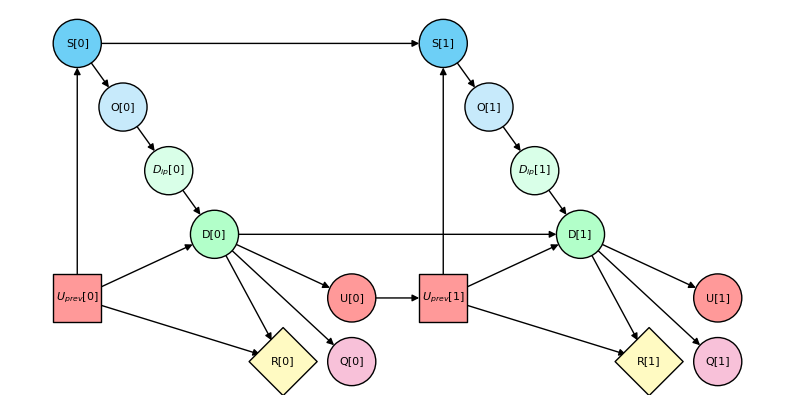

This graph represents the interactions between the variables maintained by a generic digital twin system, over 2 time frames.  
The variables are:
- S the physical, unknown state
- O the observations of the unknown state
- D_ip the results of the inverse problem that ingested the observations
- D the digital state, which is a probability mass function
- U the action as selected by the policy after evaluating the digital state, possibly as a distribution
- R the reward value (unused in this example)
- Q the quantities of interest (unused in this example)
- U_prev the action taken at the previous frame

The edges represent the dependency relationship between two or more variables, and the set of edges inciding on a variable allow to encode a single conditional probability distribution for the variable, conditioned on the variable's parents in the PGM.  
From partial observations of the system's variables, it is possible to efficiently infer the distributions of unobserved values in the system by leveraging the known dependencies.  

The core module defines metadata classes for Variables and Dependencies.
Although not all variables are observable, nor all dependencies can be encoded in finite conditional probability distributions, it is beneficial to build and render the associated Dynamic Bayesian Network.  
The following cells describe how to.  

In [9]:
from pgmtwin.core.variable import Variable

n_beacons = len(setup.beacons_coords)

S = Variable("S", distribution=False, discrete=True, domain=setup.state_domain)

obs_domain = np.array([[0, np.inf], [-np.pi, np.pi]] * n_beacons)
O = Variable("O", distribution=False, discrete=False, domain=obs_domain)

D_ip = Variable("D_ip", distribution=True, discrete=True, domain=setup.state_domain)
D = Variable("D", distribution=True, discrete=True, domain=setup.state_domain)

U = Variable("U", distribution=False, discrete=True, domain=setup.action_domain)
U_prev = Variable(
    "U_prev", distribution=False, discrete=True, domain=setup.action_domain
)

R = Variable("R", distribution=False, discrete=False, domain=[[-np.inf, np.inf]])
Q = Variable("Q", distribution=False, discrete=False, domain=[[-np.inf, np.inf]])

variables = [S, O, D_ip, D, U, U_prev, R, Q]

Then, we define the conditional dependencies between our variables.  
It is necessary to take care with the temporal succession: some dependencies link variables evaluated at different time frames.  

The most delicate part is in defining the conditional probability tables which translate a probability distribution in the space of the parent variables, to a probability distribution in the space of the output variable.  

The library method for the assemblage of the DBN will take care of replicating the given dependencies to all time frames applicable, but in some cases this is is not correct: for example, in this DBN the first digital state does not have the previous digital state as parent, so the parent variables differ btween frame 0 and frame 1. This is handled by explicitly specifying the two dependencies, but givin the same name to each, thus preventing replication.  

Moreover, we leverage the smoothing parameter during normalization of the cpds' columns to still allow a small probability to "impossible" events. This is needed to stabilize the inference results.  

In [10]:
from pgmtwin.core.dependency import Dependency
from pgmtwin.core.utils import normalize_cpd

n_states = len(setup.state_domain)

S2O = Dependency("observe", [(S, 0)], (O, 0))
O2D_ip = Dependency("inverse_problem", [(O, 0)], (D_ip, 0))

smoothing = 1e-6

confusion = np.eye(n_states)
confusion = normalize_cpd(confusion)

D_ip2D = Dependency("confusion", [(D_ip, 0)], (D, 0), cpd=confusion)
D2U = Dependency("policy", [(D, 0)], (U, 0))
SU_prev2S = Dependency("physical_update", [(S, 0), (U_prev, 1)], (S, 1))


u_priori_cpd = np.stack([a.get_transition_probabilities() for a in setup.actions])
u_priori_cpd = normalize_cpd(np.sum(u_priori_cpd, axis=2).T, smoothing=smoothing)

U_prev2D_0 = Dependency(
    "digital_update",
    [(U_prev, 0)],
    (D, 0),
    cpd=u_priori_cpd,
)

tmp = np.hstack([a.get_transition_probabilities() for a in setup.actions])
DU_prev2D_1 = Dependency(
    "digital_update",
    [
        (U_prev, 1),
        (D, 0),
    ],
    (D, 1),
    cpd=normalize_cpd(tmp, smoothing=smoothing),
)
U2U_prev = Dependency("action_observation", [(U, 0)], (U_prev, 1))
D2Q = Dependency("qois", [(D, 0)], (Q, 0))
SU2R = Dependency("reward", [(D, 0), (U_prev, 0)], (R, 0))

dependencies = [
    S2O,
    O2D_ip,
    D_ip2D,
    D2U,
    SU_prev2S,
    U_prev2D_0,
    DU_prev2D_1,
    U2U_prev,
    D2Q,
    SU2R,
]

In [11]:
from pgmtwin.core.pgm import get_dbn


dbn_full, _ = get_dbn(dependencies, check_model=False, verbose=False)

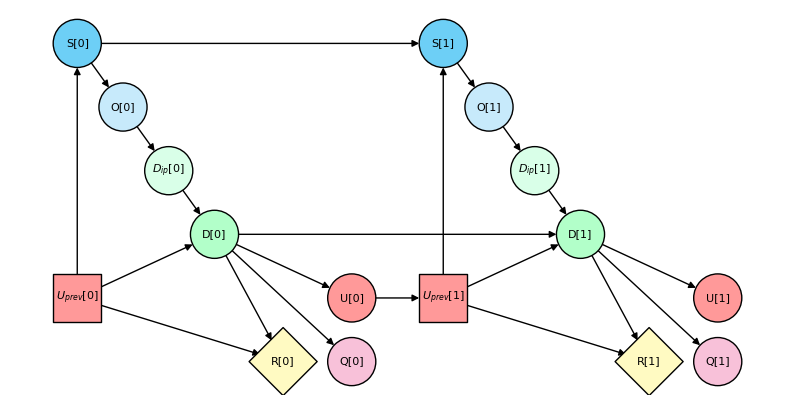

In [12]:
from pgmtwin.core.pgm import draw_structured

var_pos = {
    "S": (0, 0),
    "O": (1, -1),
    "D_ip": (2, -2),
    "D": (3, -3),
    "U": (6, -4),
    "U_prev": (0, -4),
    "R": (4.5, -5),
    "Q": (6, -5),
}
var_color = {
    "S": "#6dcff6",
    "O": "#c7eafb",
    "D_ip": "#d9ffe8",
    "D": "#b2ffc9",
    "U": "#ff9999",
    "U_prev": "#ff9999",
    "R": "#fffac2",
    "Q": "#f8c1d9",
}
var_shape = {
    "S": "o",
    "O": "o",
    "D_ip": "o",
    "D": "o",
    "U": "o",
    "U_prev": "s",
    "R": "D",
    "Q": "o",
}
var_label = {k: k for k in var_pos}
var_label["D_ip"] = "$D_{ip}$"
var_label["U_prev"] = "$U_{prev}$"

fig, ax = plt.subplots(figsize=(10, 5))

draw_structured(
    dbn_full,
    var_pos=var_pos,
    var_label=var_label,
    var_color=var_color,
    var_shape=var_shape,
    node_size=1200,
    edgecolors="black",
    font_size=8,
)

plt.axis("off")

plt.show()
plt.close()

For our specific example, we are only interested in the update of the digital state.  
In particular, we aim to leverage the knowledge of the update model together with the inverse problem results to refine the assimilation process.  
Thus, we build a smaller DBN which is limited to:
- D_ip which encodes all available knowledge from S and O
- D
- U_prev which encapsulates the policy evaluation, since this cannot be expressed with a fixed cpd


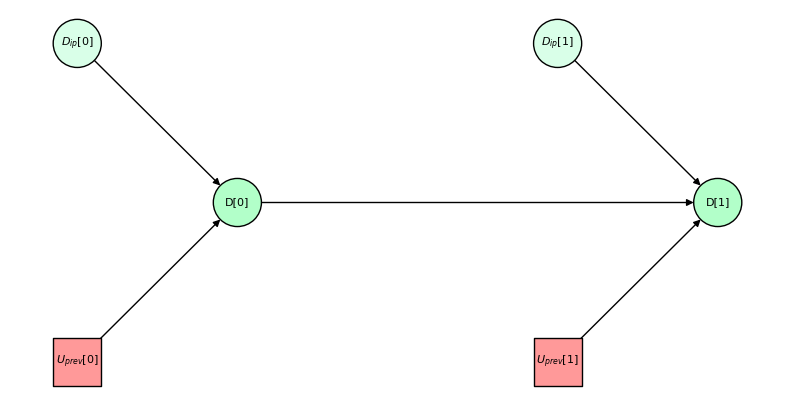

In [13]:
dbn_redux, _ = get_dbn([D_ip2D, U_prev2D_0, DU_prev2D_1])

var_pos = {
    "D_ip": (0, -2),
    "D": (1, -3),
    "U_prev": (0, -4),
}

fig, ax = plt.subplots(figsize=(10, 5))

draw_structured(
    dbn_redux,
    var_pos=var_pos,
    var_label=var_label,
    var_color=var_color,
    var_shape=var_shape,
    node_size=1200,
    edgecolors="black",
    font_size=8,
)

plt.axis("off")

plt.show()
plt.close()

With this PGM, we can combine the state evolution that the chosen Action *should* trigger on the digital state, with the new state measured via the inverse problem.  

This operation requires access to the history of states and actions, so it must take place at the level of the DigitalTwinEnv.  
We extend the RobotPathingEnv overriding the _step_assimilation method, where the inference of the new digital state is offloaded to the dbn_inference function.  
To perform inference, we supply evidence for the variables (D, 0) (D_I, 1) and (U_p, 1).  
The latter is a single scalar, but both the digital state and its estimation via inverse problem are probability distributions: the inference procedure will perform random sampling to obtain evidence.  

The inference procedure adds overhead to the assimilation step, but can be efficiently parallelized if the number of samples is high.

In [14]:
from typing import Optional
from pgmpy.inference import DBNInference
from pgmtwin.core.pgm import dbn_inference
from pgmtwin.core.utils import pgmpy_suppress_cpd_replacement_warning
from examples.robot_pathing.common import RobotPathingEnv


class RobotPathingPGMEnv(RobotPathingEnv):
    def __init__(
        self,
        noise_type: str,
        state_update_type: str,
        n_obs_assimilation: int = 1,
        pgm_n_samples_assimilation: int = 1,
        inv_solver_confusion_matrix: Optional[np.ndarray] = None,
    ):
        super().__init__(
            noise_type=noise_type,
            state_update_type=state_update_type,
            n_obs_assimilation=n_obs_assimilation,
            inv_solver_confusion_matrix=inv_solver_confusion_matrix,
        )

        with pgmpy_suppress_cpd_replacement_warning():
            self.dbn_infer = DBNInference(dbn_redux)
        self.pgm_n_samples_assimilation = pgm_n_samples_assimilation

    def _step_assimilate(self, action: Optional[int], sensor_readings: np.ndarray):
        dstate_distro = self._digital_asset.state_distro.copy()
        dinv_distro = self._digital_asset.get_assimilation_distribution(sensor_readings)

        evidence = {
            ("U_prev", 1): action if action is not None else 0,
        }
        inference_keys = [
            ("D", 1),
        ]

        inference_results = dbn_inference(
            self.dbn_infer,
            inference_keys=inference_keys,
            evidence=evidence,
            evidence_sampled_distros={
                ("D", 0): dstate_distro,
                ("D_ip", 1): dinv_distro,
            },
            n_samples=self.pgm_n_samples_assimilation,
            rng=self.np_random,
        )

        self._digital_asset.state_distro[:] = inference_results[("D", 1)]


if "robot_pathing_pgm" not in gym.registry:
    gym.register("robot_pathing_pgm", RobotPathingPGMEnv)

In [15]:
pgm_env = gym.make(
    "robot_pathing_pgm",
    noise_type="gaussian",
    state_update_type="deterministic",
    n_obs_assimilation=n_obs_assimilation,
    pgm_n_samples_assimilation=10,
    inv_solver_confusion_matrix=inv_solver_conf_matrix,
    max_episode_steps=n_simulation_iters,
)

The digital twin environment can then be simulated with the same code as before.

In [16]:
policy = RobotPathingPolicy(
    setup.state_domain,
    actions=setup.actions,
    goals=setup.goals_coords,
)

obs, info = pgm_env.reset(seed=42, options={"physical_state": np.array([0, 0])})

action, _ = policy.predict(obs, deterministic=True)

pstates = [info["physical_state"]]
dstates = [setup.state_domain.index2values(np.argmax(obs))]
goals = [policy.get_current_goal()]
actions = [setup.actions[action].name]

for f in range(n_simulation_iters):
    obs, _, terminated, truncated, info = pgm_env.step(action)

    action, _ = policy.predict(obs, deterministic=True)

    pstates.append(info["physical_state"])
    dstates.append(setup.state_domain.index2values(np.argmax(obs)))
    goals.append(policy.get_current_goal())
    actions.append(setup.actions[action].name)

    if terminated or truncated:
        break

In [17]:
for p, d, g, a in zip(
    pstates[:20],
    dstates,
    goals,
    actions,
):
    print(f"p pos {p} d pos {d} goal {g} action {a}")

p pos [0 0] d pos [0. 0.] goal [3. 2.] action east
p pos [1. 0.] d pos [1. 0.] goal [3. 2.] action north
p pos [1. 1.] d pos [1. 1.] goal [3. 2.] action east
p pos [2. 1.] d pos [2. 1.] goal [3. 2.] action north
p pos [2. 2.] d pos [2. 2.] goal [3. 2.] action east
p pos [3. 2.] d pos [3. 2.] goal [0. 4.] action west
p pos [2. 2.] d pos [2. 2.] goal [0. 4.] action north
p pos [2. 3.] d pos [2. 3.] goal [0. 4.] action west
p pos [1. 3.] d pos [1. 3.] goal [0. 4.] action north
p pos [1. 4.] d pos [1. 4.] goal [0. 4.] action west
p pos [0. 4.] d pos [0. 4.] goal [4. 2.] action east
p pos [1. 4.] d pos [1. 4.] goal [4. 2.] action east
p pos [2. 4.] d pos [2. 4.] goal [4. 2.] action south
p pos [2. 3.] d pos [2. 3.] goal [4. 2.] action east
p pos [3. 3.] d pos [3. 3.] goal [4. 2.] action south
p pos [3. 2.] d pos [3. 2.] goal [4. 2.] action east
p pos [4. 2.] d pos [4. 2.] goal [1. 3.] action west
p pos [3. 2.] d pos [3. 2.] goal [1. 3.] action west
p pos [2. 2.] d pos [2. 2.] goal [1. 3.] a